In [1]:
import json
import pathlib
from itertools import islice
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

## Load up tokenizer and model

In [3]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased').to(device)
model.classifier = nn.Sequential(
    nn.Linear(in_features=768, out_features=800, bias=True),
    nn.Linear(in_features=800, out_features=5, bias=True),
).to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

## Create and load dataset

**Note that there are 533581 examples in our dataset**

In [4]:
class YelpDataset(torch.utils.data.Dataset):
    """Yelp reviews dataset (533581 reviews)"""

    def __init__(self, json_file='../yelp_review_training_dataset.jsonl', transform=None):
        """
        Args:
            json_file (string): Path to the json file for dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open(json_file, 'r') as f:
            self.data = [json.loads(line) for line in f]
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        text, review = self.data[idx]['text'], int(self.data[idx]['stars'])
        sample = (text, review - 1) # subtract one so that one-hot label is in [0, 4]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [5]:
data = YelpDataset()

In [6]:
train = torch.utils.data.Subset(data, range(400000))
val = torch.utils.data.Subset(data, range(400000, 500000))

In [7]:
train_loader = torch.utils.data.DataLoader(train, batch_size=10,
                        shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=10,
                        shuffle=True)

## Train the classifier

In [8]:
optimizer = torch.optim.Adam(model.classifier.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='sum')

### Let's start with 1 epoch

In [9]:
val_accuracies = []
val_losses = []

In [10]:
model.train()
for i, (reviews, classes) in enumerate(tqdm(train_loader)): # use the term 'class' instead of 'rating' to denote that class = rating - 1
    
    if i % (400000 / 10 / 100) == 0: # do 100 val acc computations
        model.eval()
        testing_loss = 0
        testing_accuracy = 0
        outof = 0
        with torch.no_grad():
            for reviews, classes in islice(val_loader, 50): # 50 * batch_size examples to evaluate on
                inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
                logits = model(**inputs.to(device)).logits
                _, pred = torch.max(logits, 1)
                testing_accuracy += (pred == classes.to(device)).sum().item()
                testing_loss += loss_fn(logits, classes.to(device))
                outof += len(classes)
        print("Acc: {:.2f}%".format(testing_accuracy / outof * 100))
        val_accuracies.append(testing_accuracy / outof)
        val_losses.append(testing_loss / outof)
        model.train()
    
    optimizer.zero_grad()
    inputs = tokenizer(reviews, return_tensors="pt", padding=True, truncation=True)
    logits = model(**inputs.to(device)).logits
    loss = loss_fn(logits, classes.to(device))
    loss.backward()
    optimizer.step()
        

  0%|          | 0/40000 [00:00<?, ?it/s]

Acc: 30.60%
Acc: 70.00%
Acc: 73.00%
Acc: 70.40%
Acc: 74.80%
Acc: 70.60%
Acc: 76.00%
Acc: 67.80%
Acc: 72.60%
Acc: 71.40%
Acc: 75.40%
Acc: 71.20%
Acc: 73.80%
Acc: 68.00%
Acc: 69.00%
Acc: 72.60%
Acc: 73.60%
Acc: 72.00%
Acc: 75.20%
Acc: 62.40%
Acc: 70.40%
Acc: 70.40%
Acc: 72.40%
Acc: 75.00%
Acc: 74.40%
Acc: 76.00%
Acc: 72.80%
Acc: 74.60%
Acc: 69.40%
Acc: 74.00%
Acc: 75.00%
Acc: 71.40%
Acc: 70.40%
Acc: 71.80%
Acc: 69.40%
Acc: 69.60%
Acc: 71.60%
Acc: 72.80%
Acc: 69.60%
Acc: 72.20%
Acc: 68.60%
Acc: 75.40%
Acc: 74.00%
Acc: 72.00%
Acc: 71.20%
Acc: 72.40%
Acc: 72.00%
Acc: 72.80%
Acc: 66.80%
Acc: 71.40%
Acc: 71.00%
Acc: 72.20%
Acc: 70.80%
Acc: 68.00%
Acc: 71.60%
Acc: 73.40%
Acc: 68.20%
Acc: 73.00%
Acc: 70.20%
Acc: 70.00%
Acc: 70.00%
Acc: 71.60%
Acc: 72.40%
Acc: 74.20%
Acc: 69.20%
Acc: 70.20%
Acc: 72.00%
Acc: 70.40%
Acc: 70.00%
Acc: 71.80%
Acc: 71.20%
Acc: 74.00%
Acc: 74.60%
Acc: 70.80%
Acc: 71.80%
Acc: 73.20%
Acc: 70.20%
Acc: 69.40%
Acc: 71.00%
Acc: 73.00%
Acc: 73.40%
Acc: 68.20%
Acc: 67.60%
Acc:

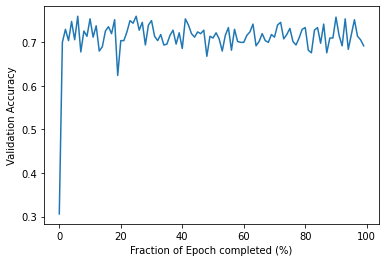

In [15]:
plt.plot(val_accuracies)
plt.ylabel("Validation Accuracy")
plt.xlabel("Fraction of Epoch completed (%)")
plt.savefig("accuracy_plot.pdf")

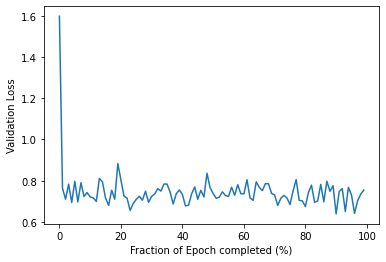

In [17]:
plt.plot(val_losses)
plt.ylabel("Validation Loss")
plt.xlabel("Fraction of Epoch completed (%)")
plt.savefig("loss_plot.pdf")